In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt

from torch.optim import lr_scheduler

batch_size = 16
learning_rate = 0.002
num_epoch = 1

## 1. CIFAR10 train, test dataset 가져오기(163MB)
MNIST : 11MB

In [2]:
cifar_train=dset.CIFAR10("CIFAR10/", train=True, transform = transforms.Compose([
                                                                                 transforms.Scale(36),
                                                                                 transforms.CenterCrop(32),
                                                                                 transforms.RandomHorizontalFlip(),
                                                                                 transforms.Lambda(lambda x: x.rotate(90)),
                                                                                 transforms.ToTensor(),
                                                                                 transforms.Normalize(mean = (0.5,0.5,0.5), std =(0.5,0.5,0.5))]), target_transform= None, download=True)
cifar_test=dset.CIFAR10("CIFAR10/", train = False, transform=transforms.Compose([
                                                                                 transforms.ToTensor(),
                                                                                 transforms.Normalize(mean = (0.5,0.5,0.5), std =(0.5,0.5,0.5))
                                                                            
]), target_transform=None, download=True)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:285: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +



Extracting CIFAR10/cifar-10-python.tar.gz to CIFAR10/
Files already downloaded and verified


## 2. 대략적인 데이터 형태

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


cifar_train 길이: 50000
cifar_test 길이: 10000
image data 형태: torch.Size([3, 32, 32])
label:  9


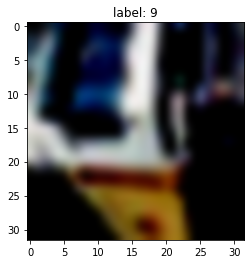

In [3]:
print("cifar_train 길이:", len(cifar_train))
print("cifar_test 길이:", len(cifar_test))

image, label = cifar_train.__getitem__(1)
print("image data 형태:", image.size())
print("label: ", label)

img = image.numpy()

r,g,b = img[0,:,:], img[1,:,:], img[2,:,:]
img2 = np.zeros((img.shape[1], img.shape[2], img.shape[0]))
img2[:,:,0], img2[:,:,1], img2[:,:,2] = r,g,b

plt.title("label: %d" %label)
plt.imshow(img2, interpolation = 'bicubic')
plt.show()

In [4]:
def ComputeAccr(dloader, imodel):
  correct = 0
  total = 0

  for j, [imgs, labels] in enumerate(dloader):
    img = Variable(imgs, volatile=True)
    label = Variable(labels)
    output = imodel.forward(img)
    _, output_index = torch.max(output, 1)

    total += label.size(0)
    correct += (output_index == label).sum().float()
  print("Accuracy of Test Data:{}".format(100*correct/total))




# CNN모델

In [5]:
train_loader = torch.utils.data.DataLoader(list(cifar_train)[:], batch_size=batch_size, shuffle=True, num_workers= 2, drop_last = True)
test_loader = torch.utils.data.DataLoader(cifar_test, batch_size=batch_size, shuffle=False, num_workers = 2, drop_last = True)

class CNN(nn.Module):
  def __init__(self):
    super(CNN,self).__init__()
    self.layer = nn.Sequential(
        nn.Conv2d(3,16,3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Conv2d(16,32,3,padding = 1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(2,2),
        nn.Conv2d(32, 64, 3, padding = 1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2,2)
    )
    self.fc_layer = nn.Sequential(
        nn.Linear(64*8*8, 100),
        nn.ReLU(),
        nn.Dropout2d(0.2),
        nn.Linear(100,10)
    )

    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        init.kaiming_normal(m.weight.data)
        m.bias.data.fill_(0)
      if isinstance(m, nn.Linear):
        init.kaiming_normal(m.weight.data)
        m.bias.data.fill_(0)

  def forward(self, x):
    out=self.layer(x)
    out=out.view(batch_size, -1)
    out = self.fc_layer(out)
    return out

model=CNN()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


In [6]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size = 20, gamma = 0.2)

num_epoch = 60
for i in range(num_epoch):
  for j,[image, label] in enumerate(train_loader):
    x=Variable(image)
    y_=Variable(label)

    optimizer.zero_grad()
    output=model.forward(x)
    loss = loss_func(output,y_)
    loss.backward()
    optimizer.step()

    if j%1000 ==0:
      print(j, loss)
  accr = ComputeAccr(test_loader, model)
  print("[Epoch : ",i,"].. loss : ", loss)

    
netname = './my_net04.pkl'
torch.save(model, netname, )

0 tensor(4.0915, grad_fn=<NllLossBackward>)
1000 tensor(2.0449, grad_fn=<NllLossBackward>)
2000 tensor(1.8061, grad_fn=<NllLossBackward>)
3000 tensor(1.8537, grad_fn=<NllLossBackward>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data:22.959999084472656
[Epoch :  0 ].. loss :  tensor(1.3333, grad_fn=<NllLossBackward>)
0 tensor(1.7274, grad_fn=<NllLossBackward>)
1000 tensor(1.7120, grad_fn=<NllLossBackward>)
2000 tensor(1.4042, grad_fn=<NllLossBackward>)
3000 tensor(1.3000, grad_fn=<NllLossBackward>)
Accuracy of Test Data:23.149999618530273
[Epoch :  1 ].. loss :  tensor(0.9329, grad_fn=<NllLossBackward>)
0 tensor(1.5307, grad_fn=<NllLossBackward>)
1000 tensor(0.8152, grad_fn=<NllLossBackward>)
2000 tensor(0.7907, grad_fn=<NllLossBackward>)
3000 tensor(1.2113, grad_fn=<NllLossBackward>)
Accuracy of Test Data:24.34000015258789
[Epoch :  2 ].. loss :  tensor(1.5897, grad_fn=<NllLossBackward>)
0 tensor(1.1034, grad_fn=<NllLossBackward>)
1000 tensor(1.3841, grad_fn=<NllLossBackward>)
2000 tensor(1.1888, grad_fn=<NllLossBackward>)
3000 tensor(0.9449, grad_fn=<NllLossBackward>)
Accuracy of Test Data:25.350000381469727
[Epoch :  3 ].. loss :  tensor(0.9878, grad_fn=<NllLossBackward>)
0 tensor(1.1420, g

KeyboardInterrupt: ignored

## print Accr